# Import Qiskit libraries:

In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, BasicAer, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.utils import algorithm_globals
from qiskit.utils import QuantumInstance
from qiskit.quantum_info import Statevector
from qiskit.extensions import Initialize

from qiskit.visualization.utils import (_bloch_multivector_data,_paulivec_data,matplotlib_close_if_inline,)
from qiskit.visualization import plot_bloch_multivector, plot_state_qsphere, plot_state_city, plot_bloch_vector
from qiskit.compiler import assemble
from qiskit.circuit.library.standard_gates import (IGate, U1Gate,XGate,YGate,ZGate,HGate,SGate,SdgGate,TGate,TdgGate,RXGate,RYGate,RZGate)

from matplotlib import pyplot as plt

import warnings
import numpy as np
import time
import random
import sys
import site

warnings.filterwarnings('ignore')
#from azure.quantum.qiskit import AzureQuantumProvider

# For Microsoft-IonQ Backends:

In [ ]:
from azure.quantum import Workspace
workspace = Workspace (
    subscription_id = "b1d7f7f8-743f-458e-b3a0-3e09734d716d",
    resource_group = "aq-hackathons",
    name = "aq-hackathon-01",
    location = "eastus"
)


In [ ]:
from azure.quantum.qiskit import AzureQuantumProvider
provider = AzureQuantumProvider (
    resource_id = "/subscriptions/b1d7f7f8-743f-458e-b3a0-3e09734d716d/resourceGroups/aq-hackathons/providers/Microsoft.Quantum/Workspaces/aq-hackathon-01",
    location = "eastus"
)

In [ ]:
print([backend.name() for backend in provider.backends()])

In [ ]:
backend = provider.get_backend("ionq.qpu")
sim = Aer.get_backend('aer_simulator')

# For IBMQ Backends:

In [6]:
#backend = provider.get_backend("ibmq_manila")
backend = BasicAer.get_backend("qasm_simulator")
sim = Aer.get_backend('aer_simulator')

## Functions:

In [7]:
# just of effects. add a delay of 1 second before performing any action
SLEEP_BETWEEN_ACTIONS = 0.1
MAX_VAL = 23
DICE_FACE = 4

single_q_gates = ['h', 'x', 'y', 'I', 'z', 's', 'sdg', 't', 'tdg'] 
single_q_param_gates = ['rx', 'ry', 'rz', 'u', 'p']
double_q_gates = ['cx', 'cz', 'cy', 'ch', 'swap']
double_q_param_gates = ['cu', 'cp', 'crx', 'cry', 'crz'] 

player_turn_text = [
    "Your turn.",
    "Go.",
    "Please proceed.",
    "Lets win this.",
    "Are you ready?",
    "In a state of Quantum Superposition?",
    "Two Hadamards decide your fate..."
]
snake_bite = [
    "boohoo",
    "bummer",
    "snake bite",
    "oh no",
    "dang"
]

ladder_jump = [
    "woohoo",
    "woww",
    "nailed it",
    "oh my God...",
    "yaayyy"
]

def welcome_msg():
    msg = """
    Welcome to the Quantum Maze
    Version: 1.0.0
    Developed by: The Seekers
    
    Rules:
      1. Initally both the players are at starting position i.e. 0. 
         Take it in turns to roll the dice. 
         Move forward the number of spaces shown on the maze.
      2. The first player to solve the quantum maze is the winner.
      3. Hit enter to roll the dice.
    
    """
    print(msg)


def get_player_names():
    player1_name = None
    while not player1_name:
        player1_name = input("Please enter a valid name for first player: ").strip()

    player2_name = None
    while not player2_name:
        player2_name = input("Please enter a valid name for second player: ").strip()

    print("\nMatch will be played between '" + player1_name + "' and '" + player2_name + "'\n")
    return player1_name, player2_name


def get_dice_value():
    time.sleep(SLEEP_BETWEEN_ACTIONS)
    #function to roll the dice
    qc = QuantumCircuit(2, 2)
    qc.name = "dice roll"
    qc.h(0)
    qc.h(1)
    qc.measure([0,1], [0,1])
    job = execute(qc, backend = backend, shots = 1).result().get_counts()
    res = list(job.keys())[0]
    val = int(res, 2)
    final_val = val if val == 1 or val == 2 or val == 3 else 4
    return final_val

def my_float(s):
    constants = {"pi": 3.14159, "e": 2.71928}
    if s in constants:
        return constants[s]
    else:
        return float(s)

def last_puzzle():
    # print("Enter the gate(s) to reset the first Qubit.")
    g1 = input("Please choose a gate to reset the qubit to |0>:").lower()
    if g1 in single_q_param_gates:
        param = my_float(input("Parameter value ="))
        g1 = (g1, param)
    else:
        pass 
    
    in1 = input("Do you want to apply more gates? (Y/N)").upper()
    if in1 == 'Y':
        g2 = input("Apply last quantum operation:").lower()
        if g2 in single_q_param_gates:
            param2 = my_float(input("Parameter value ="))
            g2 = (g2, param2)
        else:
            pass 
    else:
        g2 = 'I'

    return [g1, g2]

def quantum_maze(player_name, current_value, dice_value):
    time.sleep(SLEEP_BETWEEN_ACTIONS)
    old_value = current_value

    #print("Current Value = "+str(current_value))
    #print("Dice Value = "+str(dice_value))
    if current_value == MAX_VAL or (current_value == 19 and dice_value == 4):
      if current_value == 19 and dice_value == 4:
        current_value += 4
      if dice_value == 4:
        print("Solve this Quantum Puzzle...")
        ##bloch_sphere function?
      else:
        print("Pass the dice to next player.", "You are in the box:", current_value )
        return current_value

    elif current_value == 0 and dice_value == 4:
      current_value = 4
      #print("Current Value = "+str(current_value))
      print("You got 1 more chance! Roll the dice.")
      next_rolled_val = get_dice_value()
      if current_value+next_rolled_val < MAX_VAL:
        current_value += next_rolled_val
        print("You got {}!.".format(next_rolled_val), "You are in the box:", current_value )
    
    elif current_value == 0 and dice_value != 4:
      if current_value+dice_value <= MAX_VAL:
        current_value = current_value + dice_value
        print("You got {}, pass the dice to next player.".format(dice_value), "You are in the box:", current_value )

    elif current_value > 0 and dice_value == 4:
      if current_value+4 <= MAX_VAL:
        current_value += 4
        print("You got 1 more chance! Roll the dice.")
        next_rolled_val = get_dice_value()
        if current_value+next_rolled_val < MAX_VAL:
          current_value += next_rolled_val
          print("You got {}! Roll the dice.".format(next_rolled_val), "You are in the box:", current_value )

    elif current_value > 0 and dice_value != 4:
      if current_value+dice_value <= MAX_VAL:
        current_value = current_value + dice_value
        print("You got {}, pass the dice to next player.".format(dice_value), "You are in the box:", current_value)
    else:
      print("Pass the chance to player-2")
      final_value = current_value
    #print("\n" + player_name + " moved from " + str(old_value) + " to " + str(current_value))
    return current_value


    Welcome to the Quantum Maze
    Version: 1.0.0
    Developed by: The Seekers
    
    Rules:
      1. Initally both the players are at starting position i.e. 0. 
         Take it in turns to roll the dice. 
         Move forward the number of spaces shown on the maze.
      2. The first player to solve the quantum maze is the winner.
      3. Hit enter to roll the dice.
    
    


Please enter a valid name for first player:  j
Please enter a valid name for second player:  k



Match will be played between 'j' and 'k'




j: Lets win this. Hit the enter to roll dice:  



Rolling dice...
You got 2
j moving....
You got 2, pass the dice to next player. You are in the box: 2



k: Are you ready? Hit the enter to roll dice:  



Rolling dice...
You got 4
k moving....
You got 1 more chance! Roll the dice.
You got 3!. You are in the box: 7
7



j: Go. Hit the enter to roll dice:  



Rolling dice...
You got 1
j moving....
You got 1, pass the dice to next player. You are in the box: 3



k: Please proceed. Hit the enter to roll dice:  



Rolling dice...
You got 1
k moving....
You got 1, pass the dice to next player. You are in the box: 8
8



j: Go. Hit the enter to roll dice:  



Rolling dice...
You got 3
j moving....
You got 3, pass the dice to next player. You are in the box: 6



k: Please proceed. Hit the enter to roll dice:  



Rolling dice...
You got 1
k moving....
You got 1, pass the dice to next player. You are in the box: 9
9



j: Are you ready? Hit the enter to roll dice:  



Rolling dice...
You got 2
j moving....
You got 2, pass the dice to next player. You are in the box: 8



k: Lets win this. Hit the enter to roll dice:  



Rolling dice...
You got 3
k moving....
You got 3, pass the dice to next player. You are in the box: 12
12



j: Two Hadamards decide your fate... Hit the enter to roll dice:  



Rolling dice...
You got 2
j moving....
You got 2, pass the dice to next player. You are in the box: 10



k: Are you ready? Hit the enter to roll dice:  



Rolling dice...
You got 1
k moving....
You got 1, pass the dice to next player. You are in the box: 13
13



j: In a state of Quantum Superposition? Hit the enter to roll dice:  



Rolling dice...
You got 1
j moving....
You got 1, pass the dice to next player. You are in the box: 11



k: Please proceed. Hit the enter to roll dice:  



Rolling dice...
You got 3
k moving....
You got 3, pass the dice to next player. You are in the box: 16
16



j: Please proceed. Hit the enter to roll dice:  



Rolling dice...
You got 4
j moving....
You got 1 more chance! Roll the dice.
You got 4! Roll the dice. You are in the box: 19



k: Lets win this. Hit the enter to roll dice:  



Rolling dice...
You got 2
k moving....
You got 2, pass the dice to next player. You are in the box: 18
18



j: Lets win this. Hit the enter to roll dice:  



Rolling dice...
You got 2
j moving....
You got 2, pass the dice to next player. You are in the box: 21



k: Lets win this. Hit the enter to roll dice:  



Rolling dice...
You got 2
k moving....
You got 2, pass the dice to next player. You are in the box: 20
20



j: Go. Hit the enter to roll dice:  



Rolling dice...
You got 2
j moving....
You got 2, pass the dice to next player. You are in the box: 23


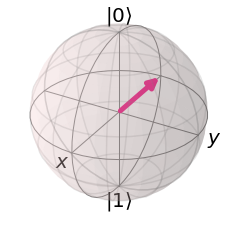

Please choose a gate to reset the qubit to |0>: u
Parameter value = 1.57
Do you want to apply more gates? (Y/N) n





Thats it.

j won the game.
Congratulations j

Thank you for playing the game.


SystemExit: 1

In [10]:
gate_list = ['I', 'X', 'Y', 'Z', 'H', 'S', 'T', 'Sdg', 'Tdg', 'RX', 'RY', 'RZ', 'U']

def blc_spr(state, title="", figsize=None, *, rho=None, filename=None):

    # Data
    bloch_data = _bloch_multivector_data(state)
    num = len(bloch_data)
    width, height = plt.figaspect(1 / num)
    fig = plt.figure(figsize=(width, height))
    for i in range(num):
        pos = i
        ax = fig.add_subplot(1, num, i + 1, projection="3d")
        #plot_bloch_vector(bloch_data[i], "qubit " + str(pos), ax=ax, figsize=figsize)
        plot_bloch_vector(bloch_data[i], ax=ax, figsize=figsize)
    fig.suptitle(title, fontsize=16, y=1.01)
    #matplotlib_close_if_inline(fig)
    return fig


def rand_bloch(num_qbits = 1, seed = None):
    gate_list = [XGate,IGate,XGate,HGate,YGate,ZGate,HGate,YGate,SGate,HGate,TGate,HGate]

    if seed is None:
        seed = np.random.randint(0, np.iinfo(np.int32).max)

    rng = np.random.default_rng(seed)
    operat = rng.choice(gate_list)
    operat1 = rng.choice(gate_list)
    op = operat()
    op1 = operat1()
    pi = np.pi

    qc = QuantumCircuit(1)
    qc.h([0])
    qc.append(op, [0])
    qc.append(op1, [0])
    qc.save_statevector()
    qobj = assemble(qc)  
    state = sim.run(qobj).result().get_statevector()
    return state

def state_vec_circ(state):
    inp = [state[0], state[1]]
    svc = QuantumCircuit(1)  
    initial_state = inp
    svc.initialize(initial_state, 0) 
    return svc

# state = rand_bloch()

def final_bloch_operation(g, state):
    q =QuantumRegister(1, 'q')
    c = ClassicalRegister(1, 'c')
    qc = QuantumCircuit(q,c)
    #state = state
    psi = Statevector(state)
    init_gate = Initialize(psi)
    init_gate.label = "code"
    qc.append(init_gate, [0])
    
    for i in range(len(g)):
        if type(g[i]) is tuple:
            gate = g[i][0]
            param = float(g[i][1])
            if gate == 'rx':
                qc.rx(param , [0]) 
            elif gate == 'ry':
                qc.ry(param, [0])
            elif gate == 'rz':
                qc.rz(param, [0])
            elif gate == 'u':
                qc.ry(param, [0])
            elif gate == 'p':
                qc.p(param, [0])
            else:
                pass
        else:
            if g[i] == 'h':
                qc.h([0])
            elif g[i] == 'x':
                qc.x([0])
            elif g[i] == 'y':
                qc.y([0])
            elif g[i] == 'z':
                qc.z([0])
            elif g[i] == 'i':
                qc.barrier()
            elif g[i] == 't':
                qc.t([0])
            elif g[i] == 'tdg':
                qc.tdg([0])
            elif g[i] == 's':
                qc.s([0])
            elif g[i] == 'sdg':
                qc.sdg([0])
            else:
                pass
    qc.measure([0],[0])
    # sim = Aer.get_backend('aer_simulator')
    qc.save_statevector()
    res = sim.run(qc, shots = 1000).result().get_counts()
    return res


def check_win(player_name, position):
    time.sleep(SLEEP_BETWEEN_ACTIONS)
    if MAX_VAL == position:
        state = rand_bloch()
        blc_spr(state)
        plt.pause(1)
        gate = last_puzzle()
        counts = final_bloch_operation(gate, state)
        key_counts = [ key for key in counts if counts[key] >40]
        if len(key_counts) ==1 and key_counts[0] == '0':
            print("\n\n\nThats it.\n\n" + player_name + " won the game.")
            print("Congratulations " + player_name)
            print("\nThank you for playing the game.")
            sys.exit('1')

def start():
    welcome_msg()
    time.sleep(SLEEP_BETWEEN_ACTIONS)
    player1_name, player2_name = get_player_names()
    time.sleep(SLEEP_BETWEEN_ACTIONS)

    player1_current_position = 0
    player2_current_position = 0

    while True:
        time.sleep(SLEEP_BETWEEN_ACTIONS)
        input_1 = input("\n" + player1_name + ": " + random.choice(player_turn_text) + " Hit the enter to roll dice: ")
        print("\nRolling dice...")
        dice_value = get_dice_value()
        print("You got", dice_value)
        time.sleep(SLEEP_BETWEEN_ACTIONS)
        print(player1_name + " moving....")
        player1_current_position = quantum_maze(player1_name, player1_current_position, dice_value)
        
        if player1_current_position == MAX_VAL:
            check_win(player1_name, player1_current_position)
        else:
            pass 
        
        time.sleep(1)
        
        input_2 = input("\n" + player2_name + ": " + random.choice(player_turn_text) + " Hit the enter to roll dice: ")
        print("\nRolling dice...")
        dice_value = get_dice_value()
        print("You got", dice_value)
        time.sleep(SLEEP_BETWEEN_ACTIONS)
        print(player2_name + " moving....")
        player2_current_position = quantum_maze(player2_name, player2_current_position, dice_value)
        print(player2_current_position)
        if player2_current_position == MAX_VAL:
            check_win(player2_name, player2_current_position)            
        else:
            pass
            
if __name__ == "__main__":
    start()